In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-1])

DF_TOTAL_T=pd.read_csv(my_path_py+'\\DatosRaw\\DEN_2015to2020.csv', sep=',')

In [3]:
listaDistrito = DF_TOTAL_T['Dep-Prov-Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
print('Son ', len(listaDistrito), ' distritos')
listaDistrito.sort()
#print(listaDistrito)

Son  505  distritos


In [4]:
timeSeries = pd.read_csv(my_path_py+'\\DatosRaw\\SerieTemporal_2015to2020.csv', sep=',')
timeSeries = timeSeries.fillna(0.00001)

## Funciones de Distancias

In [5]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [6]:
n= timeSeries.shape[0]
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.000001)

In [7]:
timeSeries.shape

(505, 318)

## Matriz de distancia euclidiana

In [8]:
#Euclidean
euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        euclidean_dist[i,j] = euclidean(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

In [9]:
euclidean_distDF = pd.DataFrame(euclidean_dist)
euclidean_distDF.to_csv('MatrizEuclidiana_RB.csv', index=False)

## Matriz de DTW 

In [10]:
#DTW 
dtw_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        dtw_dist[i,j] = fast_DTW(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())
    

In [11]:
dtw_distDF = pd.DataFrame(dtw_dist)
dtw_distDF.to_csv('MatrizDTW_RB.csv', index=False)

## Matriz de correlación de Pearson

In [12]:
corr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        corr_dist[i,j] = corr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

In [13]:
corr_distDF = pd.DataFrame(corr_dist)
corr_distDF.to_csv('MatrizPearson_RB.csv', index=False)

## Matriz de correlación de Spearman

In [14]:
#scorr
scorr_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(0,n):
       # print("j",j)
        scorr_dist[i,j] = scorr(timeSeries.iloc[i].values.flatten(), timeSeries.iloc[j].values.flatten())

In [15]:
scorr_distDF = pd.DataFrame(scorr_dist)
scorr_distDF.to_csv('MatrizSpearman_RB.csv', index=False)

## DEFINICIÓN DEL NÚMERO DE CLUSTERS K

In [16]:
k=6

In [17]:
from sklearn.preprocessing import LabelEncoder
DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

In [20]:
import scipy.cluster.hierarchy as hac
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
SIL =[]
CHZ_ =[]
DUNN_ =[]
DAVIES_ =[]

#Experimentos HAC
HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(euclidean_dist)
print("HAC + euclidian distance: ")
sil = silhouette_score(euclidean_dist, HAC_euc)
cal= calinski_harabasz_score(euclidean_dist, HAC_euc)
davies_ = davies_bouldin_score(euclidean_dist, HAC_euc)
try:
    dunn_ = dunn(HAC_euc, euclidean_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)

SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("-------------------")

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
sil = silhouette_score(corr_dist, HAC_corr)
cal= calinski_harabasz_score(corr_dist, HAC_corr)
davies_ = davies_bouldin_score(corr_dist, HAC_corr)
try:
    dunn_ = dunn(HAC_corr, corr_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("-------------------")

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(scorr_dist)
print("HAC + scorr distance: ")
sil = silhouette_score(scorr_dist, HAC_scorr)
cal= calinski_harabasz_score(scorr_dist, HAC_scorr)
davies_ = davies_bouldin_score(scorr_dist, HAC_scorr)
try:
    dunn_ = dunn(HAC_scorr, scorr_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("-------------------")

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_dist)
print("HAC + dtw distance: ")
sil = silhouette_score(dtw_dist, HAC_dtw)
cal= calinski_harabasz_score(dtw_dist, HAC_dtw)
davies_ = davies_bouldin_score(dtw_dist, HAC_dtw)
try:
    dunn_ = dunn(HAC_dtw, dtw_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

HAC + euclidian distance: 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


SC:  0.534851752387855
CHZ:  1622.2190119339145
DUNN:  0.07117307326397436
Davies:  0.6097520536333082
-------------------
HAC + corr distance: 
SC:  0.28383014918924665
CHZ:  199.09999407186524
DUNN:  0.7649964468928894
Davies:  1.2259684237302093
-------------------
HAC + scorr distance: 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


SC:  0.3113289065144307
CHZ:  290.76537388620625
DUNN:  0.6241110638746884
Davies:  1.326173865788506
-------------------
HAC + dtw distance: 
SC:  0.5182755794424393
CHZ:  894.3305417768833
DUNN:  0.12343182946528086
Davies:  0.8320309232030402


In [21]:
from sklearn.cluster import KMeans, DBSCAN

km_euc = KMeans(n_clusters=k).fit_predict(euclidean_dist)
silhouette_avg=silhouette_score(euclidean_dist, km_euc)
print("KM + euclidian distance: ")
sil = silhouette_score(euclidean_dist, km_euc)
cal= calinski_harabasz_score(euclidean_dist, km_euc)
davies_ = davies_bouldin_score(euclidean_dist, km_euc)
try:
    dunn_ = dunn(km_euc, euclidean_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)

SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("-------------------------")

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
sil = silhouette_score(corr_dist, km_corr)
cal= calinski_harabasz_score(corr_dist, km_corr)
davies_ = davies_bouldin_score(corr_dist, km_corr)
try:
    dunn_ = dunn(km_corr, corr_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("-------------------------")

km_scorr = KMeans(n_clusters=k).fit_predict(scorr_dist)
print("KM + scorr distance: ")
HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(scorr_dist)
print("HAC + scorr distance: ")
sil = silhouette_score(scorr_dist, km_scorr)
cal= calinski_harabasz_score(scorr_dist, km_scorr)
davies_ = davies_bouldin_score(scorr_dist, km_scorr)
try:
    dunn_ = dunn(km_scorr, scorr_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("-------------------------")

km_dtw = KMeans(n_clusters=k).fit_predict(dtw_dist)
print("KM + dtw distance: ")
sil = silhouette_score(dtw_dist, km_dtw)
cal= calinski_harabasz_score(dtw_dist, km_dtw)
davies_ = davies_bouldin_score(dtw_dist, km_dtw)
try:
    dunn_ = dunn(km_dtw, dtw_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

KM + euclidian distance: 
SC:  0.6420110883502711
CHZ:  1888.1791866961803
DUNN:  0.1032978845426554
Davies:  0.5967450351658529
-------------------------
KM + corr distance: 
SC:  0.3207647807971665
CHZ:  226.5387451522159
DUNN:  0.7067503754018208
Davies:  1.1645464184166199
-------------------------
KM + scorr distance: 
HAC + scorr distance: 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


SC:  0.3605793000600041
CHZ:  349.95876900387736
DUNN:  0.6666036965984464
Davies:  1.1861414479488033
-------------------------
KM + dtw distance: 
SC:  0.5531784927882855
CHZ:  941.5628360682331
DUNN:  0.12692566430758323
Davies:  0.8280531817649589


# Experimentos DBSCAN

El puntaje es negativo porque los puntos están en promedio más cerca de otro cluster, que del cuál ha sido asignado

Epsilon máximo:  3.38


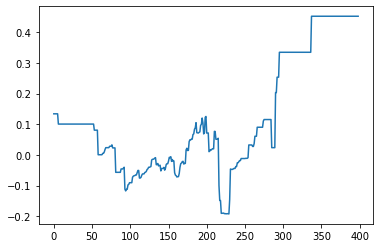

In [28]:
epsilon_lista = np.arange (0.01, 4, 0.01)
sil_list = []
for e in epsilon_lista:
    try:
        DB_corr = DBSCAN(eps=e, min_samples=3).fit_predict(corr_dist)
        sil = silhouette_score(corr_dist, DB_corr)
        sil_list.append(sil)
    except:
        pass
plt.plot(sil_list)
print('Epsilon máximo: ', epsilon_lista[np.argmax(sil_list)])

In [36]:
DB_euc = DBSCAN(eps=220, min_samples=3).fit_predict(euclidean_dist)
print("DBScan + euclidian distance: ")
sil = silhouette_score(euclidean_dist, DB_euc)
cal= calinski_harabasz_score(euclidean_dist, DB_euc)
davies_ = davies_bouldin_score(euclidean_dist, DB_euc)
try:
    dunn_ = dunn(DB_euc, euclidean_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)

SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("---------------------------")

#CON CORRELATION
DB_corr = DBSCAN(eps=0.0001, min_samples=3).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")
sil = silhouette_score(corr_dist, DB_corr)
cal= calinski_harabasz_score(corr_dist, DB_corr)
davies_ = davies_bouldin_score(corr_dist, DB_corr)
try:
    dunn_ = dunn(DB_corr, corr_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

print("---------------------------")

#CON SPEARMAN
DB_scorr = DBSCAN(eps=0.0001, min_samples=3).fit_predict(scorr_dist)
print("DBSCAN + scorr distance: ")
sil = silhouette_score(scorr_dist, DB_scorr)
cal= calinski_harabasz_score(scorr_dist, DB_scorr)
davies_ = davies_bouldin_score(scorr_dist, DB_scorr)
try:
    dunn_ = dunn(DB_scorr, scorr_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)
SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)
print("---------------------------")

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=220, min_samples=3).fit_predict(dtw_dist)
print("DBSCAN + dtw distance: ")
sil = silhouette_score(dtw_dist, DB_dtw)
cal= calinski_harabasz_score(dtw_dist, DB_dtw)
davies_ = davies_bouldin_score(dtw_dist, DB_dtw)
try:
    dunn_ = dunn(DB_dtw, dtw_dist, 'farthest', 'farthest')
except:
    dunn_ = np.nan
print("SC: ", sil)
print("CHZ: ", cal)
print("DUNN: ", dunn_)
print("Davies: ", davies_)

SIL.append(sil)
CHZ_.append(cal)
DUNN_.append(dunn_)
DAVIES_.append(davies_)

DBScan + euclidian distance: 
SC:  -0.08679084486943357
CHZ:  16.331312851482576
DUNN:  0.013431494370827848
Davies:  1.0363044202057627
---------------------------
DBSCAN + corr distance: 
SC:  0.1204306855699088
CHZ:  50.285161174967705
DUNN:  0.5000000008847683
Davies:  0.6548001682205572
---------------------------
DBSCAN + scorr distance: 
SC:  0.003954676931857233
CHZ:  29.713624120313963
DUNN:  0.5095165170737823
Davies:  0.7729046829210541
---------------------------
DBSCAN + dtw distance: 
SC:  -0.352693543427287
CHZ:  2.1473629278985107
DUNN:  0.00012751222052198436
Davies:  1.2487347696299782


In [23]:
aux2 = pd.DataFrame()
aux2['Dep-Prov-Distrito'] =listaDistrito
aux2['Cluster KM Eu'] = km_euc
aux2['Cluster HAC Eu'] = HAC_euc
aux2['Cluster DB Pear'] = DB_corr
aux2.to_csv('ClusterRB_Peru.csv', index = False)

In [24]:
np.unique(DB_corr)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16], dtype=int64)

In [25]:
list_m = []    
list_m.append('Euclidean')
list_m.append('Pearson')
list_m.append('Spearman')
list_m.append('DTW')

df_sc = pd.DataFrame()   
df_sc['Metrica'] = list_m

df_sc['SIL HAC RB'] = [SIL[0], SIL[1], SIL[2], SIL[3]]
df_sc['SIL KM RB'] = [SIL[4], SIL[5], SIL[6], SIL[7]]
df_sc['SIL DB RB'] = [SIL[8], SIL[9], SIL[10], SIL[11]]

df_sc['CHZ HAC RB'] = [CHZ_[0], CHZ_[1], CHZ_[2], CHZ_[3]]
df_sc['CHZ KM RB'] = [CHZ_[4], CHZ_[5], CHZ_[6], CHZ_[7]]
df_sc['CHZ DB RB'] = [CHZ_[8], CHZ_[9], CHZ_[10], CHZ_[11]]


df_sc['DUNN HAC RB'] = [DUNN_[0], DUNN_[1], DUNN_[2], DUNN_[3]]
df_sc['DUNN KM RB'] = [DUNN_[4], DUNN_[5], DUNN_[6], DUNN_[7]]
df_sc['DUNN DB RB'] = [DUNN_[8], DUNN_[9], DUNN_[10], DUNN_[11]]

df_sc['DAVIES HAC RB'] = [DAVIES_[0], DAVIES_[1], DAVIES_[2], DAVIES_[3]]
df_sc['DAVIES KM RB'] = [DAVIES_[4], DAVIES_[5], DAVIES_[6], DAVIES_[7]]
df_sc['DAVIES DB RB'] = [DAVIES_[8], DAVIES_[9], DAVIES_[10], DAVIES_[11]]


df_sc

,Metrica,SIL HAC RB,SIL KM RB,SIL DB RB,CHZ HAC RB,CHZ KM RB,CHZ DB RB,DUNN HAC RB,DUNN KM RB,DUNN DB RB,DAVIES HAC RB,DAVIES KM RB,DAVIES DB RB
0,Euclidean,0.534852,0.642011,-0.086791,1622.219012,1888.179187,16.331313,0.071173,0.103298,0.013431,0.609752,0.596745,1.036304
1,Pearson,0.283830,0.320765,-0.067819,199.099994,226.538745,40.312687,0.764996,0.706750,0.530597,1.225968,1.164546,1.349860
2,Spearman,0.311329,0.360579,0.107166,290.765374,349.958769,82.570507,0.624111,0.666604,0.579049,1.326174,1.186141,1.151248
3,DTW,0.518276,0.553178,-0.392916,894.330542,941.562836,2.370290,0.123432,0.126926,0.000230,0.832031,0.828053,1.274098


In [26]:
df_sc.to_csv('SilScoreRB_2015to2020.csv', index=False)